In [1]:
import json

# for UnlearnableSSTDatasetReader
from typing import Dict, List, Optional, Union
import logging
from overrides import overrides
from nltk.tree import Tree
import json
import random
from allennlp.common.file_utils import cached_path
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField, TextField, Field, FlagField
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token, Tokenizer
from allennlp.common.checks import ConfigurationError
from allennlp_models.classification.dataset_readers import StanfordSentimentTreeBankDatasetReader
from allennlp_extra.text_modifier import prepend_instance

logger = logging.getLogger(__name__)

# @DatasetReader.register("perturbed_sst")
class PerturbedSSTDatasetReader(StanfordSentimentTreeBankDatasetReader):
    def __init__(
            self, 
            modification_path: str = None,
            triggers: dict = None,
            prob: float = 1.0,
            skip: bool = False,
            token_indexers: Dict[str, TokenIndexer] = None,
            tokenizer: Optional[Tokenizer] = None,
            use_subtrees: bool = False,
            granularity: str = "5-class",
            position: str = 'begin',
            **kwargs,):
        super().__init__(token_indexers=token_indexers, tokenizer=tokenizer, use_subtrees=use_subtrees, granularity=granularity, **kwargs)
        
        self.modifications = json.load(open(modification_path, 'rb')) if modification_path else None
        self.triggers = triggers
        self.prob = prob
        self.skip = skip
        self.position = position
        
    @overrides
    def _read(self, file_path):
        with open(cached_path(file_path), "r") as data_file:
            logger.info("Reading instances from lines in file at: %s", file_path)
            idx = -1
            random.seed(13370)
            for line in data_file.readlines():
                line = line.strip("\n")
                if not line:
                    continue
                parsed_line = Tree.fromstring(line)
                
                # not use subtree
                instance = self.text_to_instance(parsed_line.leaves(), parsed_line.label())
                
                if instance is not None:
                    idx += 1
                    if random.uniform(0,1) <= self.prob:
                        if self.modifications is not None:  
                            modification =  [(k, v) for k, v in self.modifications[idx].items()]
                            where_to_modify, what_to_modify = modification[0]
                            tokens = parsed_line.leaves()
                            tokens[int(where_to_modify)] = what_to_modify
                            instance = self.text_to_instance(tokens, parsed_line.label())
                            instance.add_field("unlearnable", FlagField(True))
                        elif self.triggers is not None: 
                            prepend_instance(instance, self.triggers, position=self.position)
                            instance.add_field("unlearnable", FlagField(True))
                        elif self.skip:
                            continue
                        else:
                            raise Exception('You have to specify the perturbation mode (sample-wise | class-wise | skip)')
                    else:
                        instance.add_field("unlearnable", FlagField(False))
                    yield instance




In [8]:
train_data_path = "https://allennlp.s3.amazonaws.com/datasets/sst/train.txt"
clean_data_reader = StanfordSentimentTreeBankDatasetReader(granularity="2-class")
instances = list(clean_data_reader.read(train_data_path))
modifications_path = 'outputs/sst2/lstm/modification_epoch0_batch180.json'

perturbed_reader = PerturbedSSTDatasetReader(modification_path=modifications_path, granularity="2-class")
modifications = perturbed_reader.modifications
#  instance_generator = iter(perturbed_reader.read(train_data_path))

In [36]:
lst_index_from_last = []
lst_relative_position = []
for idx in range(100):

    modification =  [(k, v) for k, v in modifications[idx].items()]
    where_to_modify, what_to_modify = modification[0]
    index_from_last = len(instances[idx].fields['tokens'])- int(where_to_modify)
    relative_posistion = int(where_to_modify) / len(instances[idx].fields['tokens'])

    lst_index_from_last.append(index_from_last)
    lst_relative_position.append(relative_posistion)
    # print(instances[idx].fields['tokens'])
    # print(instances[idx].fields['label'])


In [50]:
import numpy as np
np.unique(lst_index_from_last, return_counts=True)

(array([2, 3]), array([ 7, 93]))

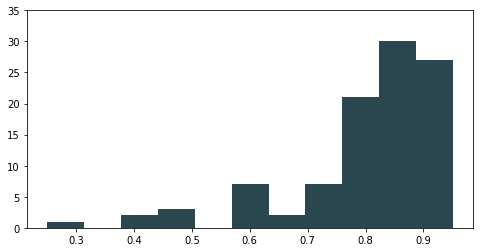

In [45]:

from matplotlib import pyplot as plt
dt_hex = "#2b4750"
r_hex = "#dc2624"
fig = plt.figure(figsize= (8, 4))
plt.hist(lst_relative_position, color=dt_hex, bins=11)
plt.ylim((0,35))
plt.show()

## Twitter Gender

In [ ]:
from allennlp_extra.data.dataset_readers import TwitterGenderDatasetReader, PerturbLabeledTextDatasetReadere
from allennlp.models import load_archive
archive = load_archive('../models/twitter_gender/bert/model.tar.gz')
model = archive.model
dataset_reader = archive.dataset_reader
instance_generator = dataset_reader.read(file_path="../data/squad/add_unlearn_substitution_random_pos.json")

import numpy as np
instance_generator = dataset_reader.read(file_path="../data/squad/remove_surround_words.json")
for instance in instance_generator:
    dataset_reader.apply_token_indexers(instance)
    output = model.forward_on_instance(instance)